# Fastai Course DL from the Foundations Train on Imagenette 
> Imagenette and Training our classifier (Lesson 5 Part 3)

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/logo.png

## Fastai Imagenet(te) training
FP16 should allow 2x speed ups in theory, practicaly it also depends on the number of fp16 vs fp32 cores on your GPU. 

In [4]:
#collapse
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
#collapse

from exp.nb_10c import *

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=1681)

In [8]:
#collapse
path = Path("/media/cedric/Datasets/imagenette2-160/")

In [11]:
size = 128 
tfms = [make_rgb, RandomResizedCrop(size,scale=(0.35,1)),np_to_float,PilRandomFlip()]

bs = 64

il = ImageList.from_files(path,tfms=tfms)
sd = SplitData.split_by_func(il,partial(grandparent_splitter,valid_name='val'))
ll = label_by_func(sd,parent_labeler,proc_y=CategoryProcessor())

ll.valid.x.tfms = [make_rgb,CenterCrop(size),np_to_float]

data = ll.to_databunch(bs,c_in=3,c_out=10,num_workers=8)

## XResNet

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=1701)

In [38]:
#collapse_show
def pass_through(x): return x

class Flatten(nn.Module): 
    def forward(self,x): return x.view(x.size(0),-1)
    
def conv(cin,cout,ks=3, stride=1,bias=False): 
    return nn.Conv2d(cin,cout,kernel_size=ks,stride=stride,padding=ks//2,bias=bias)

In [48]:
#collapse_show
activation = nn.ReLU(inplace=True)

def init_cnn(m): 
    if getattr(m,'bias',None) is not None : nn.init.constant(m.bias,0)
    if isinstance(m,(nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv_layer(cin,cout,ks=3,stride=1,zero_bn=False,act=True):
    bn = nn.BatchNorm2d(cout)
    nn.init.constant_(bn.weight,0. if zero_bn else 1.)
    layers = [conv(cin,cout,ks,stride),bn]
    if act : layers.append(activation)
    return nn.Sequential(*layers)

In [58]:
#collapse_show
class ResBlock(nn.Module):
    def __init__(self,expansion,ni,nh,stride=1):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        #layers
        #smaller nets
        if expansion == 1 : 
                layers = [conv_layer(ni,nh,3,stride=stride), 
                     conv_layer(nh,nf,3,zero_bn=True,act=False)]
        #larger Nets ResNet-D Path A
        else : 
                layers = [conv_layer(ni,nh,1), 
                          conv_layer(ni,nh,3,stride=stride),
                          conv_layer(ni,nf,1,zero_bn=True,act=False)]
                
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni == nf else conv_layer(ni,nf,1,act=False)
        self.pool = noop if stride == 1 else nn.AvgPool2d(2,ceil_mode=False)
        
    def forward(self,x): return act_fn(self.convs(x)+ self.idconv(self.pool(x)))
        

### ResBlock Details
Batch Norm sometimes has weights of 0 and sometimes 1 during init. It allows us to init the Conv branch to 0 and the identity mapping to 1. The gradient won't explode that way. 
ResNet 50 and onwards use 3 convs, smaller ones use 2. They also use Bottleneck layers (64 filters-> 16filters -> 64 filters), the normal block for larger ResNets. ResNet-D also uses downsample to make sure the two branches can be added. So when stride is not 1, and AvgPool layer with stride of 2 is deployed for different grid size, and 1x1 conv to change the number of filters (if not equal). 
![images](images/resnetd.png)




In [85]:
#collapse_show 
class XResNet(nn.Sequential):
    @classmethod 
    def create(cls,expansion,layers,c_in = 3,c_out=1000): 
        nfs = [c_in,(c_in+1)*8,64,64]
        stem = [conv_layer(nfs[i],nfs[i+1],stride=2 if i==0 else 1)
               for i in range(3)]
        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion,nfs[i],nfs[i+1],
                                     n_blocks=l,stride=1 if i==0 else 2)
                     for i,l in enumerate(layers)]
        res = cls(*stem,nn.MaxPool2d(kernel_size=3,stride=2,padding=1),*res_layers,
                  nn.AdaptiveAvgPool2d(1),Flatten(),nn.Linear(nfs[-1]*expansion,c_out))
        init_cnn(res)
        return res
    
    @staticmethod
    def _make_layer(expansion,ni,nf,n_blocks,stride): 
        return nn.Sequential(*[ResBlock(expansion,ni if i==0 else  nf,nf,stride if i==0 else 1) 
                              for i in range(n_blocks)])
        
        

In [86]:
#collapse_show
def xresnet18 (**kwargs): return XResNet.create(1, [2, 2,  2, 2], **kwargs)
def xresnet34 (**kwargs): return XResNet.create(1, [3, 4,  6, 3], **kwargs)
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)
def xresnet101(**kwargs): return XResNet.create(4, [3, 4, 23, 3], **kwargs)
def xresnet152(**kwargs): return XResNet.create(4, [3, 8, 36, 3], **kwargs)

## Train

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=2515)

In [87]:
#collapse_show
cbfs = [partial(AvgStatsCallback,accuracy), ProgressCallback, CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette),
#         partial(MixUp, alpha=0.2)
       ]

In [88]:
#collapse_show
loss_func = LabelSmoothingCrossEntropy()
arch = partial(xresnet18, c_out=10)
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [89]:
#collapse_show
def get_batch(dl, learn):
    learn.xb,learn.yb = next(iter(dl))
    learn.do_begin_fit(0)
    learn('begin_batch')
    learn('after_fit')
    return learn.xb,learn.yb

We need to replace the old `model_summary` since it used to take a `Runner`.

In [90]:
#collapse_show
def model_summary(model, data, find_all=False, print_mod=False):
    xb,yb = get_batch(data.valid_dl, learn)
    mods = find_modules(model, is_lin_layer) if find_all else model.children()
    f = lambda hook,mod,inp,out: print(f"====\n{mod}\n" if print_mod else "", out.shape)
    with Hooks(mods, f) as hooks: learn.model(xb)

In [91]:
#collapse
learn = Learner(arch(), data, loss_func, lr=1, cb_funcs=cbfs, opt_func=opt_func)

/home/cedric/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  """


In [92]:
#collapse
learn.model = learn.model.cuda()
model_summary(learn.model, data, print_mod=False)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


 torch.Size([128, 32, 64, 64])
 torch.Size([128, 64, 64, 64])
 torch.Size([128, 64, 64, 64])
 torch.Size([128, 64, 32, 32])
 torch.Size([128, 64, 32, 32])
 torch.Size([128, 128, 16, 16])
 torch.Size([128, 256, 8, 8])
 torch.Size([128, 512, 4, 4])
 torch.Size([128, 512, 1, 1])
 torch.Size([128, 512])
 torch.Size([128, 10])


In [93]:
#collapse
arch = partial(xresnet34, c_out=10)

In [94]:
#collapse
learn = Learner(arch(), data, loss_func, lr=1, cb_funcs=cbfs, opt_func=opt_func)

/home/cedric/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  """


In [96]:
#collapse
learn.fit(1, cbs=[LR_Find(), Recorder()])

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


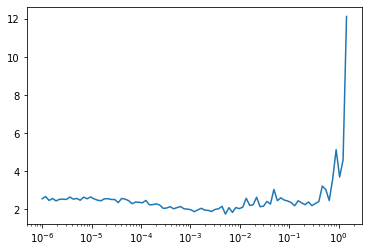

In [97]:
#collapse
learn.recorder.plot(3)

In [98]:
#collapse_show
def create_phases(phases):
    phases = listify(phases)
    return phases + [1-sum(phases)]

In [99]:
#collapse_show
print(create_phases(0.3))
print(create_phases([0.3,0.2]))

[0.3, 0.7]
[0.3, 0.2, 0.5]


In [100]:
#collapse_show
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

In [101]:
#collapse_show
cbsched = [
    ParamScheduler('lr', sched_lr),
    ParamScheduler('mom', sched_mom)]

In [102]:
#collapse_show
learn = Learner(arch(), data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

/home/cedric/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  """


In [103]:
#collapse_show
learn.fit(5, cbs=cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.747138,0.461189,2.137488,0.448408,00:20
1,1.530650,0.573239,1.779503,0.470064,00:20
2,1.386309,0.634280,1.324897,0.672357,00:20
3,1.207779,0.713275,1.158664,0.729172,00:20
4,1.045097,0.778435,0.997302,0.799745,00:20


## cnn_learner

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=2711)

In [26]:
#collapse_show
def cnn_learner(arch, data, loss_func, opt_func, c_in=None, c_out=None,
                lr=1e-2, cuda=True, norm=None, progress=True, mixup=0, xtra_cb=None, **kwargs):
    cbfs = [partial(AvgStatsCallback,accuracy)]+listify(xtra_cb)
    if progress: cbfs.append(ProgressCallback)
    if cuda:     cbfs.append(CudaCallback)
    if norm:     cbfs.append(partial(BatchTransformXCallback, norm))
    if mixup:    cbfs.append(partial(MixUp, mixup))
    arch_args = {}
    if not c_in : c_in  = data.c_in
    if not c_out: c_out = data.c_out
    if c_in:  arch_args['c_in' ]=c_in
    if c_out: arch_args['c_out']=c_out
    return Learner(arch(**arch_args), data, loss_func, opt_func=opt_func, lr=lr, cb_funcs=cbfs, **kwargs)

In [27]:
#collapse_show
learn = cnn_learner(xresnet34, data, loss_func, opt_func, norm=norm_imagenette)

In [28]:
#collapse_show

learn.fit(5, cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.734203,0.474813,1.960827,0.469299,00:18
1,1.525025,0.574506,2.046430,0.447643,00:18
2,1.396191,0.626888,1.789930,0.493248,00:18
3,1.216749,0.706833,1.156404,0.729427,00:18
4,1.043234,0.776956,1.005148,0.792102,00:18


## Imagenet

You can see all this put together in the fastai [imagenet training script](https://github.com/fastai/fastai/blob/master/examples/train_imagenet.py). It's the same as what we've seen so far, except it also handles multi-GPU training. So how well does this work?

We trained for 60 epochs, and got an error of 5.9%, compared to the official PyTorch resnet which gets 7.5% error in 90 epochs! Our xresnet 50 training even surpasses standard resnet 152, which trains for 50% more epochs and has 3x as many layers.